# Create SparkSession

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Online_Retails").getOrCreate()

# Load Dataset file

In [3]:
df = spark.read.csv("Online_Retail.csv",header=True,inferSchema=True)
df.show(5)
df.printSchema()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/01/2010 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/01/2010 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/01/2010 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/01/2010 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/01/2010 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows
root

# Data Cleaning & Transformation 

In [4]:
from pyspark.sql.functions import to_timestamp,col

# Convert InvoiceDate to timestamp
df = df.withColumn("InvoiceDate", to_timestamp("InvoiceDate", "MM/dd/yyyy HH:mm:ss"))


# Create new column TotalPrice
df = df.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# Drop rows with missing CustomerID
df = df.na.drop(subset=["CustomerID"])


# Exploratory Data Analysis (EDA)

In [5]:
# Check total rows & Columns

print(f"Rows: {df.count()}, Columns: {len(df.columns)}")
df.show(5)

Rows: 406829, Columns: 9
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     

In [5]:
df.printSchema()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)



In [7]:
# Count null in each column

from pyspark.sql.functions import count, when, isnan

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+----------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|TotalPrice|
+---------+---------+-----------+--------+-----------+---------+----------+-------+----------+
|        0|        0|          0|       0|          0|        0|         0|      0|         0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+----------+



In [8]:
# Top 5 most sold products

df.groupBy("Description").sum("Quantity").orderBy("sum(Quantity)",ascending=False).show(5)

+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|WORLD WAR 2 GLIDE...|        53215|
|JUMBO BAG RED RET...|        45066|
|ASSORTED COLOUR B...|        35314|
|WHITE HANGING HEA...|        34147|
|PACK OF 72 RETROS...|        33409|
+--------------------+-------------+
only showing top 5 rows


In [9]:
# Revenue by date.

from pyspark.sql.functions import to_date

df = df.withColumn("Date", to_date("InvoiceDate"))
df.groupBy("Date").sum("TotalPrice").orderBy("Date").show(5)

+----------+------------------+
|      Date|   sum(TotalPrice)|
+----------+------------------+
|2010-12-01| 46051.26000000007|
|2010-12-02|  45775.4299999999|
|2010-12-03|22598.460000000086|
|2010-12-05|31380.600000000162|
|2010-12-06|30465.080000000165|
+----------+------------------+
only showing top 5 rows


In [9]:
# Total sales per country

df.groupBy("Country").sum("TotalPrice").orderBy("sum(TotalPrice)",ascending=False).show()

+---------------+------------------+
|        Country|   sum(TotalPrice)|
+---------------+------------------+
| United Kingdom| 6767873.393999982|
|    Netherlands|         284661.54|
|           EIRE|         250285.22|
|        Germany|221698.21000000008|
|         France| 196712.8400000001|
|      Australia|137077.26999999996|
|    Switzerland| 55739.39999999996|
|          Spain| 54774.58000000001|
|        Belgium|          40910.96|
|         Sweden|          36595.91|
|          Japan|          35340.62|
|         Norway|          35163.46|
|       Portugal|          29059.81|
|        Finland|22326.739999999998|
|Channel Islands|          20086.29|
|        Denmark|          18768.14|
|          Italy|          16890.51|
|         Cyprus|12946.289999999997|
|        Austria|10154.320000000002|
|      Singapore|           9120.39|
+---------------+------------------+
only showing top 20 rows


# Spark SQL 

In [10]:
# Register Temp View

df.createOrReplaceTempView("Retail")

In [12]:
# Total Sales by Country(SQL)

spark.sql(""" Select Country, SUM(TotalPrice) as TotalSales 
              FROM Retail group BY Country
              ORDER BY TotalSales DESC """).show()

+---------------+------------------+
|        Country|        TotalSales|
+---------------+------------------+
| United Kingdom| 6767873.393999982|
|    Netherlands|         284661.54|
|           EIRE|         250285.22|
|        Germany|221698.21000000008|
|         France| 196712.8400000001|
|      Australia|137077.26999999996|
|    Switzerland| 55739.39999999996|
|          Spain| 54774.58000000001|
|        Belgium|          40910.96|
|         Sweden|          36595.91|
|          Japan|          35340.62|
|         Norway|          35163.46|
|       Portugal|          29059.81|
|        Finland|22326.739999999998|
|Channel Islands|          20086.29|
|        Denmark|          18768.14|
|          Italy|          16890.51|
|         Cyprus|12946.289999999997|
|        Austria|10154.320000000002|
|      Singapore|           9120.39|
+---------------+------------------+
only showing top 20 rows


In [13]:
# Total Spent Per Customer

spark.sql(""" SELECT CustomerID, Round(SUM(TotalPrice),2) As TotalSpent
              FROM Retail
              GROUP BY CustomerID
              ORDER BY TotalSpent DESC
              """).show()

+----------+----------+
|CustomerID|TotalSpent|
+----------+----------+
|     14646| 279489.02|
|     18102| 256438.49|
|     17450| 187482.17|
|     14911| 132572.62|
|     12415| 123725.45|
|     14156| 113384.14|
|     17511|  88125.38|
|     16684|  65892.08|
|     13694|   62653.1|
|     15311|  59419.34|
|     13089|  57385.88|
|     14096|  57120.91|
|     15061|  54228.74|
|     17949|  52750.84|
|     15769|  51823.72|
|     16029|  50992.61|
|     14298|  50862.44|
|     14088|  50415.49|
|     17841|  40340.78|
|     13798|  36351.42|
+----------+----------+
only showing top 20 rows


# Visualization Using Matplotlib

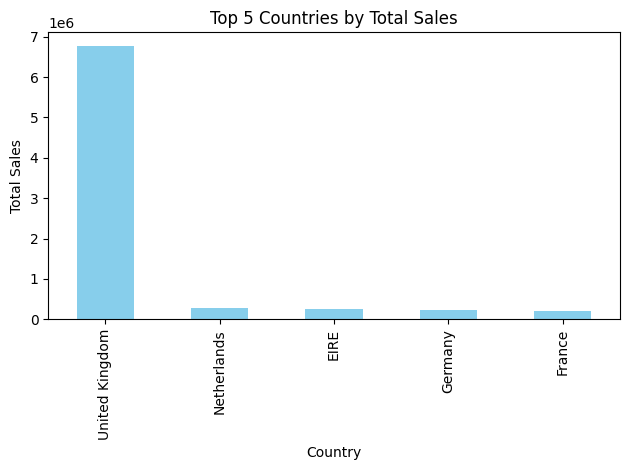

In [16]:
import matplotlib.pyplot as plt

df_pd = df.toPandas()

#Top Countries by total sales
top_countries = df_pd.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(5)

top_countries.plot(kind="bar",title="Top 5 Countries by Total Sales", ylabel ="Total Sales", xlabel="Country",color="skyblue")
plt.tight_layout()
plt.show()

+----+-----+------------------+
|Year|Month|    MonthlyRevenue|
+----+-----+------------------+
|2010|   12| 483799.7400000211|
|2011|    1|351981.28000000934|
|2011|    2| 348853.6300000104|
|2011|    3| 456917.8700000194|
|2011|    4|  376744.411000002|
|2011|    5| 525573.3500000058|
|2011|    6|472509.24999999814|
|2011|    7| 461147.6010000081|
|2011|    8|477008.41000000155|
|2011|    9| 776529.8419999995|
|2011|   10| 782777.8800000135|
|2011|   11| 956109.6600000056|
|2011|   12|297920.47000000207|
+----+-----+------------------+



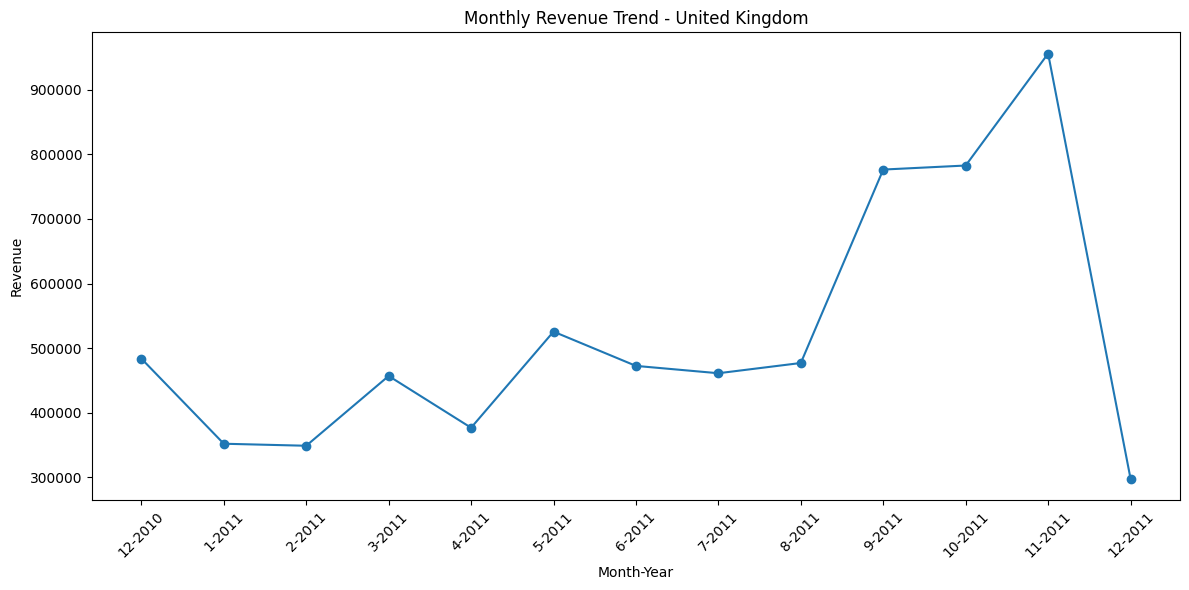

In [17]:
from pyspark.sql.functions import month, year, sum


# Filter for United Kingdom
df_top_country = df.filter(df["Country"] == "United Kingdom")

# Extract month and year, then aggregate
monthly_sales = df_top_country.withColumn("Month", month("InvoiceDate")) \
    .withColumn("Year", year("InvoiceDate")) \
    .groupBy("Year", "Month") \
    .agg(sum("TotalPrice").alias("MonthlyRevenue")) \
    .orderBy("Year", "Month")

# Show result
monthly_sales.show()

# Convert to Pandas
pd_monthly_sales = monthly_sales.toPandas()

# Plot
plt.figure(figsize=(12,6))
plt.plot(pd_monthly_sales["Month"].astype(str) + "-" + pd_monthly_sales["Year"].astype(str),
         pd_monthly_sales["MonthlyRevenue"], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend - United Kingdom")
plt.xlabel("Month-Year")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


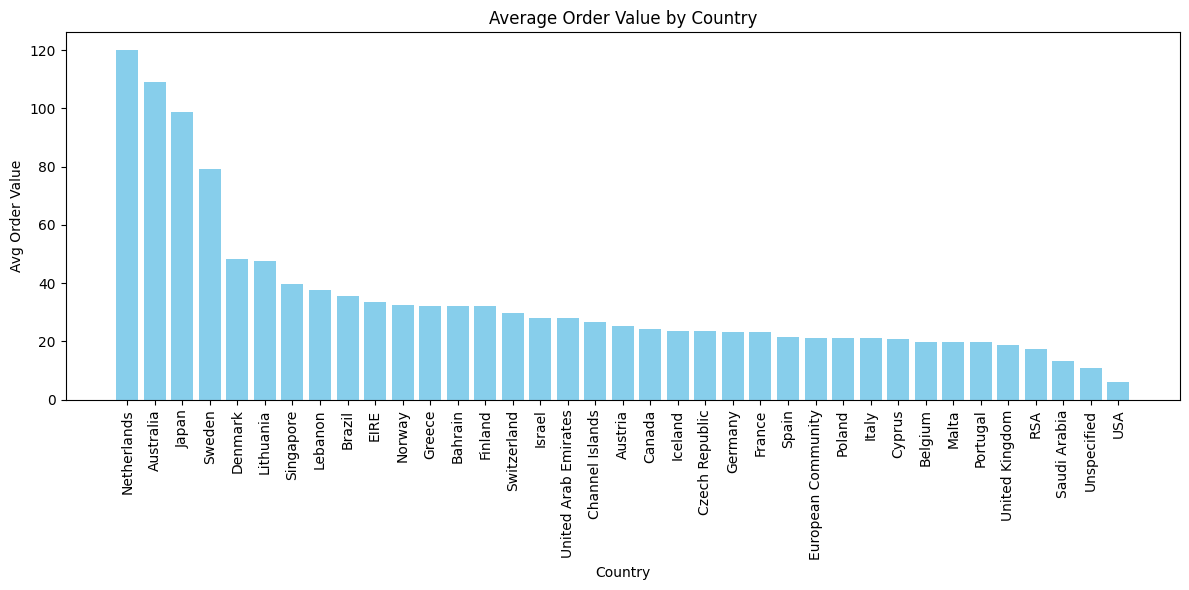

In [18]:
# Compare Average Order Value per Country

from pyspark.sql.functions import avg

# Aggregate average order value
avg_order_value = df.groupBy("Country").agg(avg("TotalPrice").alias("AvgOrderValue")).orderBy(col("AvgOrderValue").desc())

# Convert to Pandas
avg_order_value_pd = avg_order_value.toPandas()

# Plot
plt.figure(figsize=(12,6))
plt.bar(avg_order_value_pd["Country"],avg_order_value_pd["AvgOrderValue"],color='skyblue')
plt.xticks(rotation=90)
plt.title("Average Order Value by Country")
plt.xlabel("Country")
plt.ylabel("Avg Order Value")
plt.tight_layout()
plt.show()

In [22]:
# save Data using Pandas
output = df.groupBy("Country").sum("TotalPrice")

output_pd = output.toPandas()
output_pd.to_csv("sales_by_country.csv", index=False)

print(" sales_by_country data save successfully")


 sales_by_country data save successfully
